<a href="https://colab.research.google.com/github/mrreyesm/SECOM/blob/main/SECOM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECOM: Data Preparation & Modelling

# Setting Environment

## Libraries

In [ ]:
#Importing Librarys 
# For system related operations
import sys
#For the creation of dataframes and manipulating data
import pandas as pd
from pandas.api.types import is_numeric_dtype
# For numerical processing
import numpy as np
# For statistical analysis
import statistics
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy.stats import shapiro
# Iterable tools
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
# For creating models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
!{sys.executable} -m pip install boruta
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 4.3 MB/s 


## Master functions

In [ ]:
# Create function that describes each column
def descriptive_statistics(df):
  #Creates empty target dataframe
  col_names = ["FEATURE", "COUNT", "SUM",  "MEAN", "MIN", "Q1", "MEDIAN",
             "Q3", "MAX", "VARIANCE", "STANDARD_DEV", "UNIQUE_VALUES",
             "MISSING_VALUES", "PERCENTAGE_NA", "OUTLIERS_3S", "PERCENTAGE_O3S",
             "NORM_STD"]
  descriptive_df = pd.DataFrame(columns=col_names)
  # Only for numeric values
  df = df.select_dtypes(include=['int64','float64'])
  # Iterates through each column
  for col, col_name in enumerate(df.columns):
    num_values = df[col_name].count()
    sum = df[col_name].sum()
    # Central tendency
    mean = df[col_name].mean()
    min = df[col_name].min()
    q1 = df[col_name].quantile(0.25)
    median = df[col_name].quantile(0.50)
    q3 = df[col_name].quantile(0.75)
    max = df[col_name].max()
    # Volatility
    var = df[col_name].var()
    std = df[col_name].std()
    unique = df[col_name].nunique()
    missing = df[col_name].isnull().sum()
    percentage_na = df[col_name].isnull().sum() * 100 / len(df[col_name])
    # Outlier identification with zscore
    zscores = (df[col_name]-mean)/std
    zscores = zscores.to_frame()
    zoutliers = zscores.query(f"{col_name} > 3 or {col_name} < -3")
    outliers = zoutliers[col_name].count()
    perc_out = (outliers/num_values)*100
    # Min - Max normalization
    temp = (df[col_name] - min)/ (max - min)
    std_norm_values = temp.std()
    # Creates a list wirh all the values and concatenates it to target df
    desc = [col_name, num_values, sum,  mean, min, q1, median, q3,
           max, var, std, unique, missing, percentage_na, outliers,
           perc_out, std_norm_values]
    df_length = len(descriptive_df)
    descriptive_df.loc[df_length] = desc
  return descriptive_df

In [ ]:
# Create function that counts columns with above certain % of NAs
def show_features_many_nulls(df, percentage):
    features_nulls = []
    for col in df.columns:
        percentage_nulls = 100 * (df[col].isna().sum() / len(df[col]))
        if (percentage_nulls > percentage) and (col != 'TIMESTAMP' or col != 'STATUS'):
          features_nulls.append(col)
    print(f"Features with more than {percentage}% of missing values, {len(features_nulls)}")

In [ ]:
#functions to treat outliers
def outlier_replacement(data):
  copy_train_df = data.copy()
  df = data.copy()
  for col in df.columns:
      mean = df[col].mean()
      std_dev = df[col].std(axis=0)
      copy_train_df[col] = np.where(df[col] > (mean + 3*std_dev), 1, np.where(df[col] < (mean - 3*std_dev), 1, 0))                            
      df[col] = np.where(df[col] > (mean + 3*std_dev) , (mean + 3*std_dev), np.where(df[col] < (mean - 3*std_dev) , (mean - 3*std_dev), df[col]))  
  print("TOTAL OF VALUES: ", (copy_train_df.isnull().sum().sum() + copy_train_df.notnull().sum().sum()),
        "\nTOTAL OF OUTLIERS: ", copy_train_df.sum().sum(),
        "\nPERCENTAGE OF OUTLIERS REPLACED: ", (copy_train_df.sum().sum()/(copy_train_df.isnull().sum().sum() + copy_train_df.notnull().sum().sum()))*100, "%"  )
  return df

In [ ]:
#function to apply kNN imputation
def knn_imputation(data):
  scaler = MinMaxScaler(feature_range=(-1,1))
  df = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
  print("PERCENTAGE OF MISSING VALUES:",
        round((df.isnull().sum().sum()/(df.isnull().sum().sum() 
        + df.notnull().sum().sum()))*100, 2) , " %\n")
  imputer = KNNImputer(n_neighbors=5)
  df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
  print("PERCENTAGE OF MISSING VALUES AFTER IMPUTATION:",
        round((df.isnull().sum().sum()/(df.isnull().sum().sum() 
        + df.notnull().sum().sum()))*100, 2) , " %")
  return df

In [ ]:
#function to apply MICE imputation
def mice_imputation(data):
  print("PERCENTAGE OF MISSING VALUES:",
        round((data.isnull().sum().sum()/(data.isnull().sum().sum() 
        + data.notnull().sum().sum()))*100, 2) , " %")
  df = data.copy()
  lr = LinearRegression()
  mice_imputer = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, imputation_order='roman',random_state=42)
  df.iloc[:, :] = mice_imputer.fit_transform(data)
  print("PERCENTAGE OF MISSING VALUES AFTER MICE:",round((df.isnull().sum().sum()/(df.isnull().sum().sum() 
        + df.notnull().sum().sum()))*100, 2) , " %\n")
  return df

In [ ]:
#funciton to apply boruta feature selection
def boruta_feature_selection(data, target_var):
  data[target_var] = np.where(data[target_var] < 0, -1, 1)
  # define random forest classifier
  forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
  df = data.iloc[: , :-1]
  forest.fit(np.array(df), np.array(data[target_var]))
  # define Boruta feature selection method
  feat_selector = BorutaPy(forest, n_estimators='auto', random_state=42)
  # find all relevant features
  feat_selector.fit(np.array(df), np.array(data[target_var]))
  # zip my names, ranks, and decisions in a single iterable
  feature_ranks = list(zip(df.columns, 
                          feat_selector.ranking_, 
                          feat_selector.support_))
  feature_ranks = pd.DataFrame (feature_ranks, columns = ['FEATURE', 'RANK', 'KEEP'])
  boruta_features = feature_ranks.query("KEEP == True")
  boruta_features = boruta_features["FEATURE"].unique()
  boruta_features = np.append(boruta_features, target_var)
  df = data[boruta_features]
  print("FEATURES LEFT WITH BORUTA: ",df.shape[1], "\n")
  return df

In [ ]:
#funciton to apply RFE feature selection
def rfe_feature_selection(data, target_var, n_features):
  data[target_var] = np.where(data[target_var] < 0, -1, 1)
  # define random forest classifier
  forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
  df = data.iloc[: , :-1]
  forest.fit(np.array(df), np.array(data[target_var]))
  # define Boruta feature selection method
  feat_selector =RFE(forest, n_features_to_select = n_features)
  # find all relevant features
  feat_selector.fit(np.array(df), np.array(data[target_var]))
  # zip my names, ranks, and decisions in a single iterable
  feature_ranks = list(zip(df.columns, 
                          feat_selector.ranking_, 
                          feat_selector.support_))
  feature_ranks = pd.DataFrame (feature_ranks, columns = ['FEATURE', 'RANK', 'KEEP'])
  rfe_features = feature_ranks.query("KEEP == True")
  rfe_features = rfe_features["FEATURE"].unique()
  rfe_features = np.append(rfe_features, target_var)
  df = data[rfe_features]
  print("FEATURES LEFT WITH RFE: ",df.shape[1], "\n")
  return df

In [ ]:
#function to apply SMOTE balancing
def smote_balancing(data, target_var):
  print("BEFORE BALANCING")
  print(data.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  smote = SMOTE(random_state=42)
  df = data.iloc[: , :-1]
  df_data_sm, df_target_sm = smote.fit_resample(df, data[target_var])
  print("AFTER SMOTE BALANCING")
  df = pd.concat([df_data_sm, df_target_sm], axis=1)
  print(df.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  return df 

In [ ]:
#function to apply ROSE balancing
def rose_balancing(data, target_var):
  print("BEFORE BALANCING")
  print(data.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  ros = RandomOverSampler(random_state=42)
  df = data.iloc[: , :-1]
  print("AFTER ROSE BALANCING")
  df_data_ros, df_target_ros = ros.fit_resample(df, data[target_var])
  df = pd.concat([df_data_ros, df_target_ros], axis=1)
  print(df.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  return df

In [ ]:
def logistic_regression(X_train, X_test, target_var):
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  logreg = LogisticRegression()
  logreg.fit(X_train, Y_train)
  Y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  print(classification_report(Y_test, Y_pred))
  print('Average Accuracy:', accuracy_score(Y_test, Y_pred))
  logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()

In [ ]:
def logistic_regression_with_scaler(X_train, X_test, target_var):
  scaler = MinMaxScaler(feature_range=(-1,1))
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
  logreg = LogisticRegression()
  logreg.fit(X_train, Y_train)
  Y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  print(classification_report(Y_test, Y_pred))
  print('Average Accuracy:', accuracy_score(Y_test, Y_pred))
  logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()

## Loading data

In [ ]:
# Creates a dataframe with the features of the SECOM dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom_features = pd.read_csv(url, sep = ' ', header = None)
# Gives names to the columns according to their position in the dataset
secom_features.columns = ["FEATURE_"+str(col+1) for col in
                          range(0,len(secom_features.columns))]
# Creates a dataframe with the labels of the SECOM dataset and gives a col name
url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secom_labels = pd.read_csv(url, sep = " ", header = None)
secom_labels.columns = ("STATUS", "TIMESTAMP")
# Changes timestamp column to datetime format
secom_labels['TIMESTAMP'] =  pd.to_datetime(secom_labels['TIMESTAMP'])
# Merges both datasets through the index
secom_data = pd.merge(secom_labels, secom_features, left_index=True,
                      right_index=True)
secom_data.shape

(1567, 592)

# Splitting data

In [ ]:
# Subset dataset between fail and pass, split and then concatenate to keep proportion
subset = secom_data.drop(columns = "TIMESTAMP")
# select pass cases
pass_df = subset[subset["STATUS"] == 1]
X_p = pass_df.iloc[:,1:]
y_p = pass_df.loc[:,"STATUS"]
# select fail cases
fail_df = subset[subset["STATUS"] == -1]
X_f = fail_df.iloc[:,1:]
y_f = fail_df.loc[:,"STATUS"]
#Split into test and train dataset 80% 20%
X_train_p,X_test_p,y_train_p,y_test_p = train_test_split(X_p, y_p, test_size=.2,
                                                         random_state=42)
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(X_f, y_f, test_size=.2,
                                                         random_state=42)
#Concatenate results
X_train = pd.concat([X_train_p, X_train_f], axis=0)
X_test = pd.concat([X_test_p, X_test_f], axis=0)
y_train = pd.concat([y_train_p, y_train_f], axis=0)
y_test = pd.concat([y_test_p, y_test_f], axis=0)
#Examine proportions of train dataset
print("----TRAIN DATASET----\n")
X_train = pd.concat([X_train, y_train], axis=1)
print(X_train.shape)
Fail = X_train[X_train["STATUS"] == 1]
Pass = X_train[X_train["STATUS"] == -1]
print( "Fail cases: ", Fail["STATUS"].count(), "Pass cases: ", Pass["STATUS"].count())
# Overall number of missing values in the dataset
print("PERCENTAGE OF MISSING VALUES :",
      round((X_train.isnull().sum().sum()/(X_train.isnull().sum().sum() 
      + X_train.notnull().sum().sum()))*100, 2) , " %")
#Examine proportions of test dataset
print("\n----TEST DATASET----\n")
X_test = pd.concat([X_test, y_test], axis=1)
print(X_test.shape)
Fail = X_test[X_test["STATUS"] == 1]
Pass = X_test[X_test["STATUS"] == -1]
print( "Fail cases: ", Fail["STATUS"].count(), "Pass cases: ", Pass["STATUS"].count())
# Overall number of missing values in the dataset
print("PERCENTAGE OF MISSING VALUES :",
      round((X_test.isnull().sum().sum()/(X_test.isnull().sum().sum() 
      + X_test.notnull().sum().sum()))*100, 2) , " %")
show_features_many_nulls(X_test, 55)

----TRAIN DATASET----

(1253, 591)
Fail cases:  83 Pass cases:  1170
PERCENTAGE OF MISSING VALUES : 4.54  %

----TEST DATASET----

(314, 591)
Fail cases:  21 Pass cases:  293
PERCENTAGE OF MISSING VALUES : 4.49  %
Features with more than 55% of missing values, 24


#Reducing Dimensionality
We will reduce dimensionality by applying feature selection/removal. We will eliminate the features with a variance of 0, which means that all the observations are the same for a certain feature and also we will be removing the features where more than 55% of the data is missing.

In [ ]:
#Copy the Dataset to easily go back if mistakes are made
X_train_df = X_train.copy()

## High Percentage of missing values

Text(0.5, 0, 'Scaled Standard Deviation')

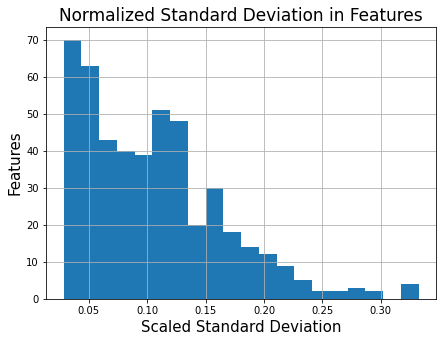

In [ ]:
features_descriptives = descriptive_statistics(X_train_df)
volatility = features_descriptives["NORM_STD"]
# Create histogram of the standar deviation of normalized values in features
plt.style.context('bmh')
plt.figure(figsize=(7,5))
volatility.hist(bins=20)
plt.title('Normalized Standard Deviation in Features', fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Scaled Standard Deviation', fontsize=15)

In [ ]:
#This code will remove the features with a High Percentage of missing values (more than 55%)
X_train_df_ = X_train_df
print("TOTAL FEATURES: ", len(X_train_df_.columns))
X_train_df = X_train_df.loc[:, X_train_df.isnull().mean() < .55]
print("FEATURES REMOVED: ", len(X_train_df_.columns)-len(X_train_df.columns)," cols with >55% Nulls"
      "\nFEATURES LEFT: ", len(X_train_df.columns))

TOTAL FEATURES:  591
FEATURES REMOVED:  24  cols with >55% Nulls
FEATURES LEFT:  567


## Low Variance

Text(0.5, 0, 'Scaled Standard Deviation')

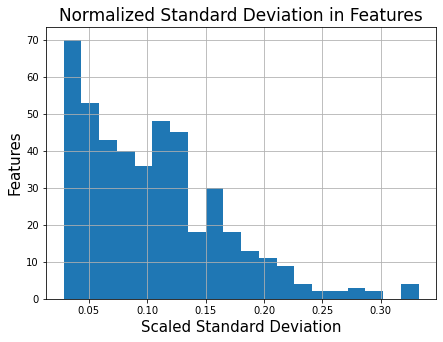

In [ ]:
features_descriptives = descriptive_statistics(X_train_df)
volatility = features_descriptives["NORM_STD"]
# Create histogram of the standar deviation of normalized values in features
plt.style.context('bmh')
plt.figure(figsize=(7,5))
volatility.hist(bins=20)
plt.title('Normalized Standard Deviation in Features', fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Scaled Standard Deviation', fontsize=15)

TOTAL FEATURES:  567 
FEATURES REMOVED:  140  featueres with stdev = 0 or whose values are equal in more than 99.5% of the feature 
FEATURES LEFT:  427 



Text(0.5, 0, 'Scaled Standard Deviation')

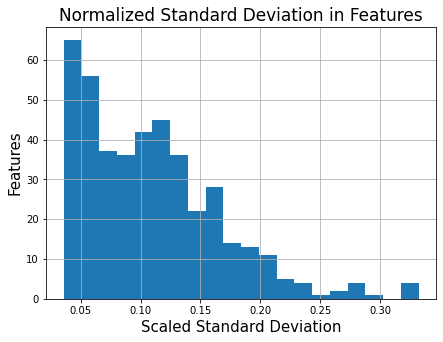

In [ ]:
X_train_dftemp = X_train_df
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_df = pd.DataFrame(scaler.fit_transform(X_train_df), columns = X_train_df.columns)
threshold = 0.995
var_threshold = threshold * (1 - threshold)
varThreshold = VarianceThreshold(var_threshold)
varThreshold.fit(X_train_df)
mask = varThreshold.get_support()
low_var_features = X_train_df.loc[:, ~mask].columns
X_train_df.drop(low_var_features, axis=1, inplace=True)
print("TOTAL FEATURES: ", len(X_train_dftemp.columns),
      "\nFEATURES REMOVED: ", len(X_train_dftemp.columns)-len(X_train_df.columns), f" featueres with stdev = 0 or whose values are equal in more than {threshold*100}% of the feature",
      "\nFEATURES LEFT: ", len(X_train_df.columns), "\n")
features_descriptives = descriptive_statistics(X_train_df)
volatility = features_descriptives["NORM_STD"].where(features_descriptives["FEATURE"] != "STATUS")
# Create histogram of the standar deviation of normalized values in features
plt.figure(figsize=(7,5))
volatility.hist(bins=20)
plt.title('Normalized Standard Deviation in Features', fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Scaled Standard Deviation', fontsize=15)

## High Correlation
Remove highly correlated features that have low correlation with target.

In [ ]:
corr_threshold = 0.99
corr_df = pd.DataFrame(columns=["FEATURE_A", "FEATURE_B", "CORRELATION"]) 
X_train_df2 =  X_train_df.loc[:, X_train_df.columns != "STATUS"]
for col_name, col_name2 in combinations(X_train_df2 , 2):
    correlation = X_train_df2[col_name].corr(X_train_df2[col_name2])
    corrlist = [col_name, col_name2, correlation]
    corr_length = len(corr_df)
    corr_df.loc[corr_length] = corrlist
highly_corr_features = corr_df.query(f"CORRELATION > {corr_threshold} | CORRELATION < -{corr_threshold}")
highly_corr_features = highly_corr_features.reset_index()
highly_corr_features = highly_corr_features.drop(columns = "index")
#Create list of features that were in the most correlated pairs
features_a = highly_corr_features["FEATURE_A"].unique()
features_b = highly_corr_features["FEATURE_B"].unique()
features = np.concatenate([features_a , features_b])
features = np.append(features, 'STATUS')
high_corr = X_train_df[features]
#remove the one that has less correlation to the target variable
corr_target = pd.DataFrame(columns=["FEATURE", "CORRELATION_WITH_TARGET_x"])
for col_name in high_corr:
    correlation = high_corr["STATUS"].corr(X_train_df[col_name])
    corrlist = [col_name, correlation]
    corr_length = len(corr_target)
    corr_target.loc[corr_length] = corrlist
corr_target = corr_target.where(corr_target["FEATURE"] != "STATUS")
corrs_target = pd.merge(corr_df, corr_target, how="inner", left_on="FEATURE_A", right_on="FEATURE")
corrs_target.rename(columns = {'CORRELATION_WITH_TARGET_x':'CORRELATION_WITH_TARGET_A'}, inplace = True)
corrs_target = pd.merge(corrs_target, corr_target, how="inner", left_on="FEATURE_B", right_on="FEATURE")
corrs_target.rename(columns = {'CORRELATION_WITH_TARGET_x':'CORRELATION_WITH_TARGET_B'}, inplace = True)
corrs_target.drop(columns=["FEATURE_x", "FEATURE_y"])
corrs_target = corrs_target[["CORRELATION",'FEATURE_A', 'CORRELATION_WITH_TARGET_A', 'FEATURE_B', 'CORRELATION_WITH_TARGET_B']]
corrs_target["lowest_corr_w_target"] = np.where( abs(corrs_target.CORRELATION_WITH_TARGET_A) < abs(corrs_target.CORRELATION_WITH_TARGET_B), corrs_target.FEATURE_A, corrs_target.FEATURE_B)
corrs_target = corrs_target .query(f"CORRELATION > {corr_threshold} | CORRELATION < -{corr_threshold}")
corrs_target.head(3)

,CORRELATION,FEATURE_A,CORRELATION_WITH_TARGET_A,FEATURE_B,CORRELATION_WITH_TARGET_B,lowest_corr_w_target
2,-1.000000,FEATURE_35,-0.026531,FEATURE_37,0.026531,FEATURE_35
9,-0.990802,FEATURE_94,0.014727,FEATURE_107,-0.014544,FEATURE_107
36,0.999980,FEATURE_5,-0.015249,FEATURE_141,-0.015210,FEATURE_141


In [ ]:
highly_corr_features_lowest_to_target = corrs_target["lowest_corr_w_target"].unique()
highly_corr_features_lowest_to_target = np.unique(highly_corr_features_lowest_to_target)
print("TOTAL FEATURES: ", len(X_train_df.columns))
X_train_dfcopy = X_train_df
X_train_df.drop(highly_corr_features_lowest_to_target, axis=1, inplace=True)
print("FEATURES REMOVED: ", len(highly_corr_features_lowest_to_target),f" cols with above +-{corr_threshold} correlation with another feature and low correlation with target"
      "\nFEATURES LEFT: ", len(X_train_df.columns))

TOTAL FEATURES:  427
FEATURES REMOVED:  80  cols with above +-0.99 correlation with another feature and low correlation with target
FEATURES LEFT:  347


In [ ]:
X_train_df_columns = ['FEATURE_1', 'FEATURE_2', 'FEATURE_3', 'FEATURE_4', 'FEATURE_5', 'FEATURE_7', 'FEATURE_8', 'FEATURE_9', 'FEATURE_10', 'FEATURE_11', 'FEATURE_12', 'FEATURE_13', 'FEATURE_15', 'FEATURE_16', 'FEATURE_17', 'FEATURE_19', 'FEATURE_20', 'FEATURE_21', 'FEATURE_22', 'FEATURE_23', 'FEATURE_24', 'FEATURE_25', 'FEATURE_26', 'FEATURE_27', 'FEATURE_28', 'FEATURE_29', 'FEATURE_30', 'FEATURE_31', 'FEATURE_32', 'FEATURE_33', 'FEATURE_34', 'FEATURE_36', 'FEATURE_37', 'FEATURE_38', 'FEATURE_39', 'FEATURE_40', 'FEATURE_41', 'FEATURE_42', 'FEATURE_44', 'FEATURE_45', 'FEATURE_46', 'FEATURE_47', 'FEATURE_48', 'FEATURE_49', 'FEATURE_51', 'FEATURE_52', 'FEATURE_54', 'FEATURE_55', 'FEATURE_56', 'FEATURE_57', 'FEATURE_58', 'FEATURE_59', 'FEATURE_60', 'FEATURE_61', 'FEATURE_62', 'FEATURE_63', 'FEATURE_64', 'FEATURE_65', 'FEATURE_66', 'FEATURE_67', 'FEATURE_68', 'FEATURE_69', 'FEATURE_71', 'FEATURE_72', 'FEATURE_73', 'FEATURE_74', 'FEATURE_76', 'FEATURE_77', 'FEATURE_78', 'FEATURE_79', 'FEATURE_80', 'FEATURE_81', 'FEATURE_82', 'FEATURE_83', 'FEATURE_84', 'FEATURE_85', 'FEATURE_87', 'FEATURE_88', 'FEATURE_89', 'FEATURE_90', 'FEATURE_91', 'FEATURE_92', 'FEATURE_93', 'FEATURE_94', 'FEATURE_95', 'FEATURE_96', 'FEATURE_97', 'FEATURE_99', 'FEATURE_100', 'FEATURE_101', 'FEATURE_102', 'FEATURE_103', 'FEATURE_104', 'FEATURE_105', 'FEATURE_106', 'FEATURE_108', 'FEATURE_109', 'FEATURE_113', 'FEATURE_114', 'FEATURE_115', 'FEATURE_116', 'FEATURE_117', 'FEATURE_118', 'FEATURE_119', 'FEATURE_120', 'FEATURE_121', 'FEATURE_122', 'FEATURE_123', 'FEATURE_124', 'FEATURE_125', 'FEATURE_126', 'FEATURE_127', 'FEATURE_128', 'FEATURE_129', 'FEATURE_130', 'FEATURE_131', 'FEATURE_132', 'FEATURE_133', 'FEATURE_134', 'FEATURE_135', 'FEATURE_138', 'FEATURE_139', 'FEATURE_140', 'FEATURE_144', 'FEATURE_146', 'FEATURE_147', 'FEATURE_151', 'FEATURE_152', 'FEATURE_153', 'FEATURE_156', 'FEATURE_157', 'FEATURE_162', 'FEATURE_163', 'FEATURE_168', 'FEATURE_169', 'FEATURE_170', 'FEATURE_172', 'FEATURE_176', 'FEATURE_177', 'FEATURE_178', 'FEATURE_181', 'FEATURE_182', 'FEATURE_183', 'FEATURE_189', 'FEATURE_196', 'FEATURE_197', 'FEATURE_198', 'FEATURE_199', 'FEATURE_200', 'FEATURE_201', 'FEATURE_202', 'FEATURE_204', 'FEATURE_205', 'FEATURE_206', 'FEATURE_209', 'FEATURE_211', 'FEATURE_212', 'FEATURE_213', 'FEATURE_214', 'FEATURE_215', 'FEATURE_216', 'FEATURE_217', 'FEATURE_218', 'FEATURE_219', 'FEATURE_222', 'FEATURE_225', 'FEATURE_228', 'FEATURE_229', 'FEATURE_239', 'FEATURE_240', 'FEATURE_248', 'FEATURE_249', 'FEATURE_250', 'FEATURE_251', 'FEATURE_255', 'FEATURE_256', 'FEATURE_269', 'FEATURE_270', 'FEATURE_271', 'FEATURE_272', 'FEATURE_273', 'FEATURE_274', 'FEATURE_275', 'FEATURE_278', 'FEATURE_279', 'FEATURE_280', 'FEATURE_281', 'FEATURE_282', 'FEATURE_283', 'FEATURE_284', 'FEATURE_286', 'FEATURE_287', 'FEATURE_289', 'FEATURE_290', 'FEATURE_291', 'FEATURE_295', 'FEATURE_296', 'FEATURE_298', 'FEATURE_299', 'FEATURE_300', 'FEATURE_301', 'FEATURE_302', 'FEATURE_303', 'FEATURE_304', 'FEATURE_305', 'FEATURE_306', 'FEATURE_307', 'FEATURE_308', 'FEATURE_309', 'FEATURE_311', 'FEATURE_312', 'FEATURE_317', 'FEATURE_318', 'FEATURE_319', 'FEATURE_320', 'FEATURE_325', 'FEATURE_332', 'FEATURE_334', 'FEATURE_335', 'FEATURE_336', 'FEATURE_337', 'FEATURE_338', 'FEATURE_341', 'FEATURE_344', 'FEATURE_345', 'FEATURE_346', 'FEATURE_347', 'FEATURE_349', 'FEATURE_350', 'FEATURE_353', 'FEATURE_354', 'FEATURE_355', 'FEATURE_356', 'FEATURE_357', 'FEATURE_358', 'FEATURE_360', 'FEATURE_361', 'FEATURE_364', 'FEATURE_366', 'FEATURE_367', 'FEATURE_368', 'FEATURE_369', 'FEATURE_377', 'FEATURE_378', 'FEATURE_386', 'FEATURE_389', 'FEATURE_391', 'FEATURE_392', 'FEATURE_393', 'FEATURE_394', 'FEATURE_406', 'FEATURE_407', 'FEATURE_408', 'FEATURE_409', 'FEATURE_410', 'FEATURE_413', 'FEATURE_414', 'FEATURE_416', 'FEATURE_418', 'FEATURE_419', 'FEATURE_420', 'FEATURE_422', 'FEATURE_424', 'FEATURE_425', 'FEATURE_426', 'FEATURE_428', 'FEATURE_431', 'FEATURE_432', 'FEATURE_433', 'FEATURE_434', 'FEATURE_435', 'FEATURE_438', 'FEATURE_439', 'FEATURE_440', 'FEATURE_442', 'FEATURE_443', 'FEATURE_444', 'FEATURE_445', 'FEATURE_455', 'FEATURE_456', 'FEATURE_461', 'FEATURE_469', 'FEATURE_472', 'FEATURE_473', 'FEATURE_474', 'FEATURE_475', 'FEATURE_477', 'FEATURE_480', 'FEATURE_481', 'FEATURE_483', 'FEATURE_484', 'FEATURE_485', 'FEATURE_486', 'FEATURE_487', 'FEATURE_488', 'FEATURE_489', 'FEATURE_490', 'FEATURE_491', 'FEATURE_492', 'FEATURE_497', 'FEATURE_498', 'FEATURE_500', 'FEATURE_501', 'FEATURE_511', 'FEATURE_512', 'FEATURE_522', 'FEATURE_523', 'FEATURE_524', 'FEATURE_525', 'FEATURE_526', 'FEATURE_540', 'FEATURE_542', 'FEATURE_543', 'FEATURE_544', 'FEATURE_545', 'FEATURE_547', 'FEATURE_548', 'FEATURE_549', 'FEATURE_551', 'FEATURE_552', 'FEATURE_553', 'FEATURE_554', 'FEATURE_556', 'FEATURE_559', 'FEATURE_560', 'FEATURE_561', 'FEATURE_562', 'FEATURE_563', 'FEATURE_564', 'FEATURE_566', 'FEATURE_567', 'FEATURE_568', 'FEATURE_569', 'FEATURE_570', 'FEATURE_571', 'FEATURE_572', 'FEATURE_574', 'FEATURE_575', 'FEATURE_576', 'FEATURE_578', 'FEATURE_583', 'FEATURE_585', 'FEATURE_587', 'FEATURE_588', 'FEATURE_589', 'FEATURE_590', 'STATUS']

Text(0.5, 0, 'Scaled Standard Deviation')

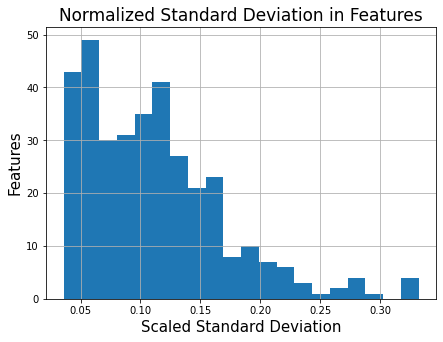

In [ ]:
features_descriptives = descriptive_statistics(X_train_df)
volatility = features_descriptives["NORM_STD"].where(features_descriptives["FEATURE"] != "STATUS")
# Create histogram of the standar deviation of normalized values in features
plt.figure(figsize=(7,5))
volatility.hist(bins=20)
plt.title('Normalized Standard Deviation in Features', fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Scaled Standard Deviation', fontsize=15)

#Outlier identification and treatment
Now we ended up with 451 columns. we removed 116 columns that had a 0 volatility value and 24 features that had more than 55% of missing values. Now it is time to treat our data, by having the outliers identified and then treating them.

Text(0.5, 0, 'Outliers')

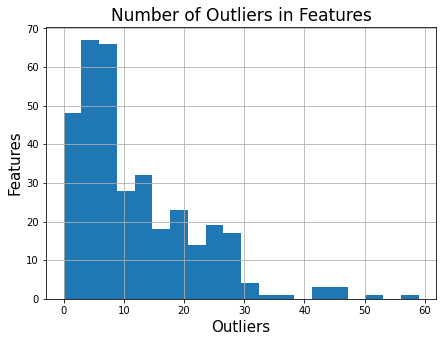

In [ ]:
# Apply function
features_descriptives = descriptive_statistics(X_train_df)
# Outliers: Values outside the 3s bounds
outliers = features_descriptives["OUTLIERS_3S"].where(features_descriptives["FEATURE"] != "STATUS")
# Create histogram of outliers in features
plt.style.context('bmh')
plt.figure(figsize=(7,5))
outliers.hist(bins=20)
plt.title('Number of Outliers in Features', fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Outliers', fontsize=15)

In [ ]:
features_descriptives.where(features_descriptives["FEATURE"] != "STATUS").sort_values(by="OUTLIERS_3S", ascending = False).head(5)

,FEATURE,COUNT,SUM,MEAN,MIN,Q1,MEDIAN,Q3,MAX,VARIANCE,STANDARD_DEV,UNIQUE_VALUES,MISSING_VALUES,PERCENTAGE_NA,OUTLIERS_3S,PERCENTAGE_O3S,NORM_STD
34,FEATURE_39,1252,176.734923,0.141162,-1.0,0.000244,0.132308,0.231654,1.0,0.057340,0.239458,321,1,0.079808,59,4.712460,0.119729
337,FEATURE_575,1253,-1136.744569,-0.907218,-1.0,-0.981833,-0.976855,-0.970985,1.0,0.096876,0.311249,701,0,0.000000,51,4.070231,0.155625
323,FEATURE_559,1253,-832.372078,-0.664303,-1.0,-0.794805,-0.739286,-0.646429,1.0,0.075314,0.274435,350,0,0.000000,45,3.591381,0.137217
196,FEATURE_296,1251,-933.962746,-0.746573,-1.0,-0.872952,-0.805339,-0.729083,1.0,0.082865,0.287863,1248,2,0.159617,45,3.597122,0.143932
336,FEATURE_574,1253,-930.050329,-0.742259,-1.0,-0.837746,-0.787324,-0.720939,1.0,0.050392,0.224481,653,0,0.000000,45,3.591381,0.112241


TOTAL OF VALUES:  434791 
TOTAL OF OUTLIERS:  4095 
PERCENTAGE OF OUTLIERS REPLACED:  0.9418318226458229 %


Text(0.5, 0, 'Outliers')

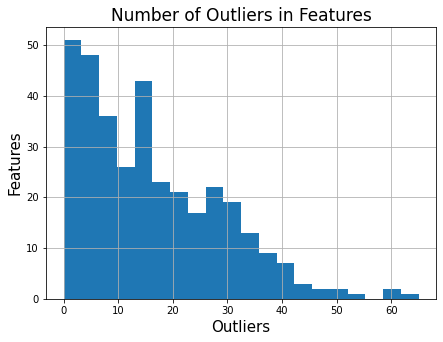

In [ ]:
copy_train_df = X_train_df.copy()
for col in X_train_df.columns:
    mean = X_train_df[col].mean()
    std_dev = X_train_df[col].std(axis=0)
    copy_train_df[col] = np.where(X_train_df[col] > (mean + 3*std_dev), 1, np.where(X_train_df[col] < (mean - 3*std_dev), 1, 0))                            
    X_train_df[col] = np.where(X_train_df[col] > (mean + 3*std_dev) , (mean + 3*std_dev), X_train_df[col])
    X_train_df[col] = np.where(X_train_df[col] < (mean - 3*std_dev) , (mean - 3*std_dev), X_train_df[col])   
print("TOTAL OF VALUES: ", (copy_train_df.isnull().sum().sum() + copy_train_df.notnull().sum().sum()),
      "\nTOTAL OF OUTLIERS: ", copy_train_df.sum().sum(),
      "\nPERCENTAGE OF OUTLIERS REPLACED: ", (copy_train_df.sum().sum()/(copy_train_df.isnull().sum().sum() + copy_train_df.notnull().sum().sum()))*100, "%"  )
features_descriptives = descriptive_statistics(X_train_df)
# Outliers: Values outside the 3s bounds
outliers = features_descriptives["OUTLIERS_3S"].where(features_descriptives["FEATURE"] != "STATUS")
# Create histogram of outliers in features
plt.style.context('bmh')
plt.figure(figsize=(7,5))
outliers.hist(bins=20)
plt.title('Number of Outliers in Features', fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Outliers', fontsize=15)

In [ ]:
features_descriptives.where(features_descriptives["FEATURE"] != "STATUS").sort_values(by="OUTLIERS_3S", ascending = False).head(5)

,FEATURE,COUNT,SUM,MEAN,MIN,Q1,MEDIAN,Q3,MAX,VARIANCE,STANDARD_DEV,UNIQUE_VALUES,MISSING_VALUES,PERCENTAGE_NA,OUTLIERS_3S,PERCENTAGE_O3S,NORM_STD
323,FEATURE_559,1253,-845.692348,-0.674934,-1.000000,-0.794805,-0.739286,-0.646429,0.159001,0.052176,0.228420,334,0,0.000000,65,5.187550,0.197084
34,FEATURE_39,1252,174.636337,0.139486,-0.577213,0.000244,0.132308,0.231654,0.859538,0.051475,0.226882,309,1,0.079808,59,4.712460,0.157913
337,FEATURE_575,1253,-1163.021130,-0.928189,-1.000000,-0.981833,-0.976855,-0.970985,0.026529,0.045171,0.212535,678,0,0.000000,59,4.708699,0.207042
338,FEATURE_576,1253,-885.423031,-0.706642,-1.000000,-0.802352,-0.748483,-0.665402,0.050355,0.035799,0.189207,522,0,0.000000,53,4.229848,0.180136
196,FEATURE_296,1251,-956.581422,-0.764653,-1.000000,-0.872952,-0.805339,-0.729083,0.117017,0.040685,0.201704,1204,2,0.159617,51,4.076739,0.180574


#Imputate missing values

In [ ]:
#Copy the Dataset to easily go back if mistakes are made
X_train_knn = X_train_df.copy()
X_train_mice = X_train_df.copy()

### KNN imputation

KNN imputation method is distance-based and it requires the data to be normalized. If we do not normalize the data, the different scalings in our data will make the process of imputation generate biased replacements for the missing values. For SECOM project, we will use Scikit-Learn’s MinMaxScaler. This will scale our features to values between 0 and 1.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_knn = pd.DataFrame(scaler.fit_transform(X_train_knn), columns = X_train_knn.columns)
print("PERCENTAGE OF MISSING VALUES :",
      round((X_train_knn.isnull().sum().sum()/(X_train_knn.isnull().sum().sum() 
      + X_train_knn.notnull().sum().sum()))*100, 2) , " %\n")

PERCENTAGE OF MISSING VALUES : 2.12  %



Now we can move forward with the KNN Imputation. We import the Scikit-Learn’s Impute package and apply it. The number of N-neighbors will  be set at 3. This means, the missing values are being replaced by the mean of 3 nearest neighbors usint the Euclidean distance.

In [ ]:
imputer = KNNImputer(n_neighbors=5)
X_train_knn = pd.DataFrame(imputer.fit_transform(X_train_knn),columns = X_train_knn.columns)
print("PERCENTAGE OF MISSING VALUES :",
      round((X_train_knn.isnull().sum().sum()/(X_train_knn.isnull().sum().sum() 
      + X_train_knn.notnull().sum().sum()))*100, 2) , " %")

PERCENTAGE OF MISSING VALUES : 0.0  %


### MICE imputation 
aprox 18m 14s to run

In [ ]:
print("PERCENTAGE OF MISSING VALUES BEFORE MICE:",
      round((X_train_mice.isnull().sum().sum()/(X_train_mice.isnull().sum().sum() 
      + X_train_mice.notnull().sum().sum()))*100, 2) , " %")

PERCENTAGE OF MISSING VALUES BEFORE MICE: 2.12  %


In [ ]:
X_train_mice_imputed = X_train_mice.copy(deep=True)
mice_imputer = IterativeImputer()
X_train_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(X_train_mice)
X_train_mice = X_train_mice_imputed

In [ ]:
print("PERCENTAGE OF MISSING VALUES AFTER MICE:",round((X_train_mice.isnull().sum().sum()/(X_train_mice.isnull().sum().sum() 
      + X_train_mice.notnull().sum().sum()))*100, 2) , " %\n")

PERCENTAGE OF MISSING VALUES AFTER MICE: 0.0  %



#Feature Selection

##Boruta

In [ ]:
# define random forest classifier
X_train_knn.STATUS = np.where(X_train_knn.STATUS < 0, -1, 1)
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
X_train_knn_data = X_train_knn.iloc[: , :-1]
forest.fit(np.array(X_train_knn_data), np.array(X_train_knn.STATUS))
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', random_state=42)
# find all relevant features
feat_selector.fit(np.array(X_train_knn_data), np.array(X_train_knn.STATUS))
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(X_train_knn_data.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))
# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(np.array(X_train_knn_data))

Feature: FEATURE_1                 Rank: 39,  Keep: False
Feature: FEATURE_2                 Rank: 260,  Keep: False
Feature: FEATURE_3                 Rank: 158,  Keep: False
Feature: FEATURE_4                 Rank: 169,  Keep: False
Feature: FEATURE_5                 Rank: 264,  Keep: False
Feature: FEATURE_7                 Rank: 138,  Keep: False
Feature: FEATURE_8                 Rank: 112,  Keep: False
Feature: FEATURE_9                 Rank: 12,  Keep: False
Feature: FEATURE_10                Rank: 209,  Keep: False
Feature: FEATURE_11                Rank: 71,  Keep: False
Feature: FEATURE_12                Rank: 86,  Keep: False
Feature: FEATURE_13                Rank: 243,  Keep: False
Feature: FEATURE_15                Rank: 61,  Keep: False
Feature: FEATURE_16                Rank: 144,  Keep: False
Feature: FEATURE_17                Rank: 96,  Keep: False
Feature: FEATURE_19                Rank: 262,  Keep: False
Feature: FEATURE_20                Rank: 28,  Keep: False
Feat

In [ ]:
feature_ranks = pd.DataFrame (feature_ranks, columns = ['FEATURE', 'RANK', 'KEEP'])
boruta_features = feature_ranks.query("KEEP == True")
boruta_features = boruta_features["FEATURE"].unique()
boruta_features = np.append(boruta_features, 'STATUS')
X_train_knn_boruta = X_train_knn[boruta_features]
print("FEATURES LEFT WITH BORUTA: ",X_train_knn_boruta.shape[1], "\n")
X_train_knn_boruta.head(1)

FEATURES LEFT WITH BORUTA:  15 



,FEATURE_34,FEATURE_60,FEATURE_65,FEATURE_66,FEATURE_91,FEATURE_104,FEATURE_122,FEATURE_125,FEATURE_130,FEATURE_131,FEATURE_206,FEATURE_248,FEATURE_511,FEATURE_564,STATUS
0,-0.346626,-0.293893,0.31204,0.189196,-0.229387,-0.404101,0.308174,0.235101,0.135963,0.608136,-0.650996,-0.374197,-0.429163,-0.319035,1


Text(0.5, 1.0, 'Correlation Heatmap')

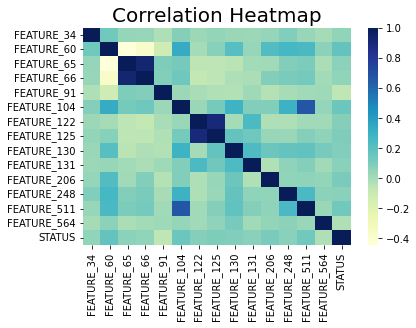

In [ ]:
sns.heatmap(X_train_knn_boruta.corr(), cmap = "YlGnBu")
plt.title('Correlation Heatmap', fontsize = 20)

## Recursive Feature Elimination

In [ ]:
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
X_train_knn_data = X_train_knn.iloc[: , :-1]
X_train_knn.STATUS = np.where(X_train_knn.STATUS < 0, -1, 1)
forest.fit(np.array(X_train_knn_data), np.array(X_train_knn.STATUS))
# define RFE feature selection method
feat_selector = RFE(forest, n_features_to_select = 25)
# find all relevant features
feat_selector.fit(np.array(X_train_knn_data), np.array(X_train_knn.STATUS))
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(X_train_knn_data.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))
# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
# call transform() on X to filter it down to selected features
X_filtered_rfe = feat_selector.transform(np.array(X_train_knn_data))

Feature: FEATURE_1                 Rank: 9,  Keep: False
Feature: FEATURE_2                 Rank: 148,  Keep: False
Feature: FEATURE_3                 Rank: 113,  Keep: False
Feature: FEATURE_4                 Rank: 166,  Keep: False
Feature: FEATURE_5                 Rank: 140,  Keep: False
Feature: FEATURE_7                 Rank: 133,  Keep: False
Feature: FEATURE_8                 Rank: 250,  Keep: False
Feature: FEATURE_9                 Rank: 25,  Keep: False
Feature: FEATURE_10                Rank: 96,  Keep: False
Feature: FEATURE_11                Rank: 303,  Keep: False
Feature: FEATURE_12                Rank: 73,  Keep: False
Feature: FEATURE_13                Rank: 272,  Keep: False
Feature: FEATURE_15                Rank: 141,  Keep: False
Feature: FEATURE_16                Rank: 69,  Keep: False
Feature: FEATURE_17                Rank: 72,  Keep: False
Feature: FEATURE_19                Rank: 152,  Keep: False
Feature: FEATURE_20                Rank: 17,  Keep: False
Featu

In [ ]:
feature_ranks = pd.DataFrame (feature_ranks, columns = ['FEATURE', 'RANK', 'KEEP'])
rfe_features = feature_ranks.query("KEEP == True")
rfe_features = rfe_features["FEATURE"].unique()
rfe_features = np.append(rfe_features, 'STATUS')
X_train_knn_rfe = X_train_knn[rfe_features]
print("FEATURES LEFT WITH RFE: ",X_train_knn_rfe.shape[1], "\n")
X_train_knn_rfe.head(1)

FEATURES LEFT WITH RFE:  26 



,FEATURE_22,FEATURE_32,FEATURE_34,FEATURE_60,FEATURE_65,FEATURE_66,FEATURE_82,FEATURE_91,FEATURE_104,FEATURE_122,...,FEATURE_320,FEATURE_337,FEATURE_349,FEATURE_424,FEATURE_461,FEATURE_469,FEATURE_511,FEATURE_564,FEATURE_574,STATUS
0,0.074841,-0.108673,-0.346626,-0.293893,0.31204,0.189196,-0.016035,-0.229387,-0.404101,0.308174,...,0.307099,-0.742954,-0.837624,0.383836,-0.163131,-0.765899,-0.429163,-0.319035,-0.588187,1


Text(0.5, 1.0, 'Correlation Heatmap')

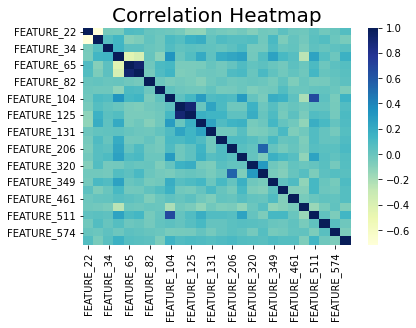

In [ ]:
sns.heatmap(X_train_knn_rfe.corr(), cmap = "YlGnBu")
plt.title('Correlation Heatmap', fontsize = 20)

#Balancing

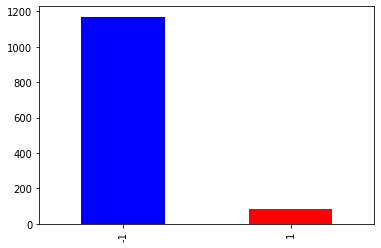

In [ ]:
X_train_knn_boruta.groupby(['STATUS']).size().reset_index().rename(columns={0:'count'})
X_train_knn_boruta.STATUS.value_counts().plot.bar(color=['blue', 'red'])

##SMOTE

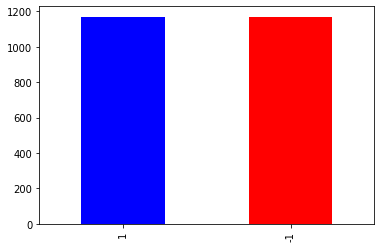

In [ ]:
smote = SMOTE(random_state=42)
X_train_knn_boruta_data = X_train_knn_boruta.iloc[: , :-1]
X_train_knn_boruta_data_sm, X_train_knn_boruta_target_sm = smote.fit_resample(X_train_knn_boruta_data, X_train_knn_boruta.STATUS)
X_train_knn_boruta_target_sm.value_counts().plot.bar(color=['blue', 'red'])

##ROSE

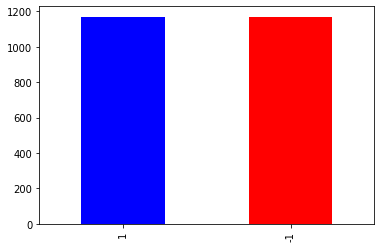

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_knn_boruta_data_ros, X_train_knn_boruta_target_ros = ros.fit_resample(X_train_knn_boruta_data, X_train_knn_boruta.STATUS)
X_train_knn_boruta_target_ros.value_counts().plot.bar(color=['blue', 'red'])

#Model

##Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_knn_boruta_data_sm, X_train_knn_boruta_target_sm)

LogisticRegression()

In [ ]:
#Copy the Dataset to easily go back if mistakes are made
X_test_df = X_test.copy()
y_test = X_test_df.STATUS

X_test_df = X_test_df.iloc[: , :-1]
#Test data preparation_ outlier treatment and knn imputation
#Outlier treatment
for col in X_test_df.columns:
    mean = X_test_df[col].mean()
    std_dev = X_test_df[col].std(axis=0)
    X_test_df[col] = np.where(X_test_df[col] > (mean + 3*std_dev) , (mean + 3*std_dev), X_test_df[col])
    X_test_df[col] = np.where(X_test_df[col] < (mean - 3*std_dev) , (mean - 3*std_dev), X_test_df[col])
#KNN imputation
scaler = MinMaxScaler(feature_range=(-1,1))
X_test_knn = pd.DataFrame(scaler.fit_transform(X_test_df), columns = X_test_df.columns)
imputer = KNNImputer(n_neighbors=5)
X_test_knn = pd.DataFrame(imputer.fit_transform(X_test_knn),columns = X_test_knn.columns)

knn_boruta_features = X_train_knn_boruta.iloc[: , :-1]
X_test_knn = X_test_knn[knn_boruta_features.columns]

y_pred = logreg.predict(X_test_knn)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_knn, y_test)))

print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.74
              precision    recall  f1-score   support

          -1       0.95      0.76      0.84       293
           1       0.12      0.48      0.20        21

    accuracy                           0.74       314
   macro avg       0.54      0.62      0.52       314
weighted avg       0.90      0.74      0.80       314



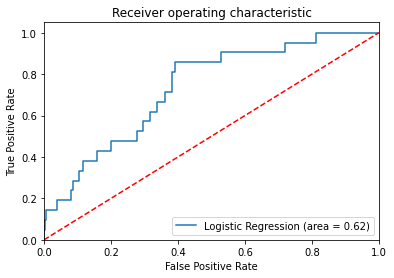

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_knn))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_knn)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#Evaluate
In the following steps we will evaluate the different combinations of data preparation to get to the best combination for a simple model.

Simple feature romoval will already be done:

* Removing features with high percentage of missing values
* Removing features with near 0 variance
* Removing from the most correlated features the one that has the lowest correlation with the target variable

We will try different combinations imputations methods, feature selection and balancing and examine the performance of a simple Logistic Regression.

##Starting point

In [ ]:
after_first_removal_columns  = X_train_df_columns

In [ ]:
print("TRAIN SET SHAPE: ", X_train.shape)
print("TEST SET SHAPE: ", X_test.shape)
print("NUMBER OF COLUMNS AFTER ROUGHT FEATURE REMOVAL", len(after_first_removal_columns))
X__train = X_train[after_first_removal_columns]
X__test = X_test[after_first_removal_columns]
print("TRAIN SET SHAPE: ", X__train.shape)
print("TEST SET SHAPE: ", X__test.shape)
print("\nTRAIN SET:")
X__train = outlier_replacement(X__train)
print("\nTEST SET:")
X__test = outlier_replacement(X__test)

TRAIN SET SHAPE:  (1253, 591)
TEST SET SHAPE:  (314, 591)
NUMBER OF COLUMNS AFTER ROUGHT FEATURE REMOVAL 347
TRAIN SET SHAPE:  (1253, 347)
TEST SET SHAPE:  (314, 347)

TRAIN SET:
TOTAL OF VALUES:  434791 
TOTAL OF OUTLIERS:  4095 
PERCENTAGE OF OUTLIERS REPLACED:  0.9418318226458229 %

TEST SET:
TOTAL OF VALUES:  108958 
TOTAL OF OUTLIERS:  1022 
PERCENTAGE OF OUTLIERS REPLACED:  0.9379761008829091 %


###KNN IMPUTATION

In [ ]:
print("\nTRAIN SET:")
X__train__knn = knn_imputation(X__train)
print("\nTEST SET:")
X__test__knn = knn_imputation(X__test)


TRAIN SET:
PERCENTAGE OF MISSING VALUES: 2.12  %

PERCENTAGE OF MISSING VALUES AFTER IMPUTATION: 0.0  %

TEST SET:
PERCENTAGE OF MISSING VALUES: 2.13  %

PERCENTAGE OF MISSING VALUES AFTER IMPUTATION: 0.0  %


###MICE IMPUTATION

In [ ]:
print("\nTRAIN SET:")
X__train__mice = mice_imputation(X__train)
print("\nTEST SET:")
X__test__mice = mice_imputation(X__test)


TRAIN SET:
PERCENTAGE OF MISSING VALUES: 2.12  %
PERCENTAGE OF MISSING VALUES AFTER MICE: 0.0  %


TEST SET:
PERCENTAGE OF MISSING VALUES: 2.13  %
PERCENTAGE OF MISSING VALUES AFTER MICE: 0.0  %



###BORUTA FEATURE SELECTION

In [ ]:
print("\nKNN TRAIN SET:")
X__train__knn__boruta = boruta_feature_selection(X__train__knn, target_var = 'STATUS')
X__test__knn__boruta = X__test__knn[X__train__knn__boruta.columns]
print("KNN BORUTA TRAIN SET SHAPE: ", X__train__knn__boruta.shape)
print("KNN BORUTA TEST SET SHAPE: ", X__test__knn__boruta.shape)
print("\nMICE TRAIN SET:")
X__train__mice__boruta = boruta_feature_selection(X__train__mice, target_var = 'STATUS')
X__test__mice__boruta = X__test__mice[X__train__mice__boruta.columns]
print("MICE BORUTA TRAIN SET SHAPE: ", X__train__mice__boruta.shape)
print("MICE BORUTA TEST SET SHAPE: ", X__test__mice__boruta.shape)


KNN TRAIN SET:
FEATURES LEFT WITH BORUTA:  15 

KNN BORUTA TRAIN SET SHAPE:  (1253, 15)
KNN BORUTA TEST SET SHAPE:  (314, 15)

MICE TRAIN SET:
FEATURES LEFT WITH BORUTA:  13 

MICE BORUTA TRAIN SET SHAPE:  (1253, 13)
MICE BORUTA TEST SET SHAPE:  (314, 13)


###RFE FEATURE SELECTION

In [ ]:
print("\nKNN TRAIN SET:")
X__train__knn__rfe = rfe_feature_selection(X__train__knn, target_var = 'STATUS', n_features = 25)
X__test__knn__rfe = X__test__knn[X__train__knn__rfe.columns]
print("KNN RFE TRAIN SET SHAPE: ", X__train__knn__rfe.shape)
print("KNN RFE TEST SET SHAPE: ", X__test__knn__rfe.shape)
print("\nMICE TRAIN SET:")
X__train__mice__rfe = rfe_feature_selection(X__train__mice, target_var = 'STATUS', n_features = 25)
X__test__mice__rfe = X__test__mice[X__train__mice__rfe.columns]
print("MICE RFE TRAIN SET SHAPE: ", X__train__mice__rfe.shape)
print("MICE RFE TEST SET SHAPE: ", X__test__mice__rfe.shape)


KNN TRAIN SET:
FEATURES LEFT WITH RFE:  26 

KNN RFE TRAIN SET SHAPE:  (1253, 26)
KNN RFE TEST SET SHAPE:  (314, 26)

MICE TRAIN SET:
FEATURES LEFT WITH RFE:  26 

MICE RFE TRAIN SET SHAPE:  (1253, 26)
MICE RFE TEST SET SHAPE:  (314, 26)


###SMOTE BALANCING

In [ ]:
print("\nKNN BORUTA TRAIN SET:")
X__train__knn__boruta__smote = smote_balancing(X__train__knn__boruta, target_var = 'STATUS')
print("\nMICE BORUTA TRAIN SET:")
X__train__mice__boruta__smote = smote_balancing(X__train__mice__boruta, target_var = 'STATUS')
print("\nKNN RFE TRAIN SET:")
X__train__knn__rfe__smote = smote_balancing(X__train__knn__rfe, target_var = 'STATUS')
print("\nMICE RFE TRAIN SET:")
X__train__mice__rfe__smote = smote_balancing(X__train__mice__rfe, target_var = 'STATUS')


KNN BORUTA TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER SMOTE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

MICE BORUTA TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER SMOTE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

KNN RFE TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER SMOTE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

MICE RFE TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER SMOTE BALANCING
   STATUS  count
0      -1   1170
1       1   1170


###ROSE BALANCING

In [ ]:
print("\nKNN BORUTA TRAIN SET:")
X__train__knn__boruta__rose =  rose_balancing(X__train__knn__boruta, target_var = 'STATUS')
print("\nMICE BORUTA TRAIN SET:")
X__train__mice__boruta__rose = rose_balancing(X__train__mice__boruta, target_var = 'STATUS')
print("\nKNN RFE TRAIN SET:")
X__train__knn__rfe__rose = rose_balancing(X__train__knn__rfe, target_var = 'STATUS')
print("\nMICE RFE TRAIN SET:")
X__train__mice__rfe__rose = rose_balancing(X__train__mice__rfe, target_var = 'STATUS')


KNN BORUTA TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER ROSE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

MICE BORUTA TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER ROSE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

KNN RFE TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER ROSE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

MICE RFE TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER ROSE BALANCING
   STATUS  count
0      -1   1170
1       1   1170


##EVALUATE DIFFERENT COMBINATIONS

###KNN BORUTA SMOTE LOGREG

Accuracy of logistic regression classifier on test set: 0.74
              precision    recall  f1-score   support

          -1       0.95      0.76      0.84       293
           1       0.12      0.48      0.20        21

    accuracy                           0.74       314
   macro avg       0.54      0.62      0.52       314
weighted avg       0.90      0.74      0.80       314

Average Accuracy: 0.7388535031847133


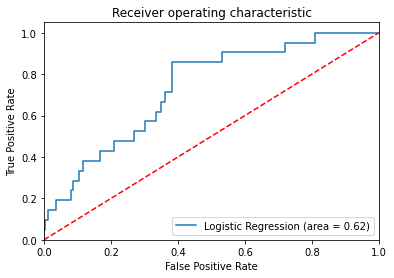

In [ ]:
logistic_regression(X__train__knn__boruta__smote, X__test__knn__boruta, target_var = 'STATUS')

###KNN BORUTA ROSE LOGREG

Accuracy of logistic regression classifier on test set: 0.75
              precision    recall  f1-score   support

          -1       0.95      0.76      0.85       293
           1       0.13      0.48      0.20        21

    accuracy                           0.75       314
   macro avg       0.54      0.62      0.52       314
weighted avg       0.90      0.75      0.81       314

Average Accuracy: 0.7452229299363057


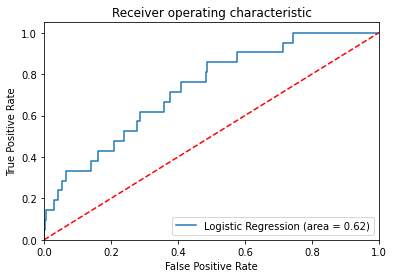

In [ ]:
logistic_regression(X__train__knn__boruta__rose, X__test__knn__boruta, target_var = 'STATUS')

###KNN RFE SMOTE LOGREG

Accuracy of logistic regression classifier on test set: 0.69
              precision    recall  f1-score   support

          -1       0.97      0.69      0.81       293
           1       0.14      0.71      0.24        21

    accuracy                           0.69       314
   macro avg       0.56      0.70      0.52       314
weighted avg       0.92      0.69      0.77       314

Average Accuracy: 0.6942675159235668


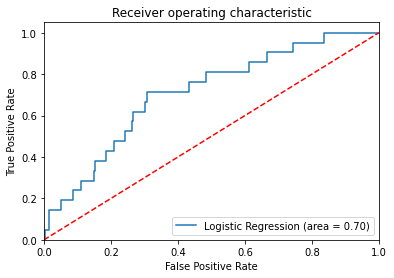

In [ ]:
logistic_regression(X__train__knn__rfe__smote, X__test__knn__rfe, target_var = 'STATUS')

###KNN RFE ROSE LOGREG

Accuracy of logistic regression classifier on test set: 0.71
              precision    recall  f1-score   support

          -1       0.96      0.72      0.82       293
           1       0.14      0.62      0.22        21

    accuracy                           0.71       314
   macro avg       0.55      0.67      0.52       314
weighted avg       0.91      0.71      0.78       314

Average Accuracy: 0.7133757961783439


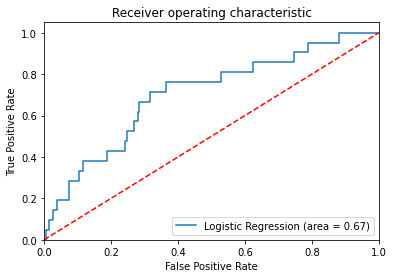

In [ ]:
logistic_regression(X__train__knn__rfe__rose, X__test__knn__rfe, target_var = 'STATUS')

###MICE BORUTA SMOTE LOGREG

Accuracy of logistic regression classifier on test set: 0.70
              precision    recall  f1-score   support

          -1       0.94      0.73      0.82       293
           1       0.09      0.38      0.15        21

    accuracy                           0.70       314
   macro avg       0.52      0.55      0.48       314
weighted avg       0.89      0.70      0.78       314

Average Accuracy: 0.7038216560509554


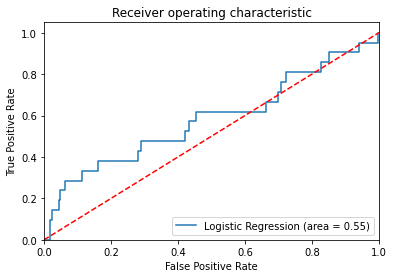

In [ ]:
logistic_regression(X__train__mice__boruta__smote, X__test__mice__boruta, target_var = 'STATUS')

MICE BORUTA SMOTE LOGREG WITH SCALER
Accuracy of logistic regression classifier on test set: 0.09
              precision    recall  f1-score   support

          -1       1.00      0.02      0.05       293
           1       0.07      1.00      0.13        21

    accuracy                           0.09       314
   macro avg       0.53      0.51      0.09       314
weighted avg       0.94      0.09      0.05       314

Average Accuracy: 0.08917197452229299


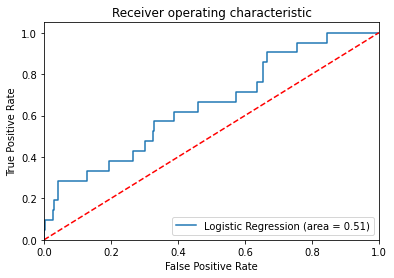

In [ ]:
print("MICE BORUTA SMOTE LOGREG WITH SCALER")
logistic_regression_with_scaler(X__train__mice__boruta__smote, X__test__mice__boruta, target_var = 'STATUS')

###MICE BORUTA ROSE LOGREG

Accuracy of logistic regression classifier on test set: 0.71
              precision    recall  f1-score   support

          -1       0.95      0.73      0.83       293
           1       0.10      0.43      0.17        21

    accuracy                           0.71       314
   macro avg       0.53      0.58      0.50       314
weighted avg       0.89      0.71      0.78       314

Average Accuracy: 0.7133757961783439


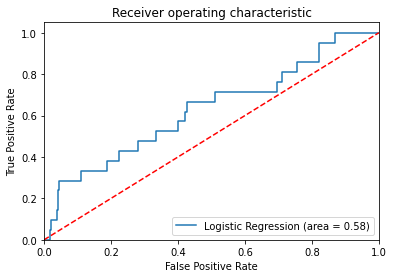

In [ ]:
logistic_regression(X__train__mice__boruta__rose, X__test__mice__boruta, target_var = 'STATUS')

###MICE RFE SMOTE LOGREG

Accuracy of logistic regression classifier on test set: 0.74
              precision    recall  f1-score   support

          -1       0.96      0.75      0.84       293
           1       0.14      0.57      0.23        21

    accuracy                           0.74       314
   macro avg       0.55      0.66      0.53       314
weighted avg       0.91      0.74      0.80       314

Average Accuracy: 0.7388535031847133


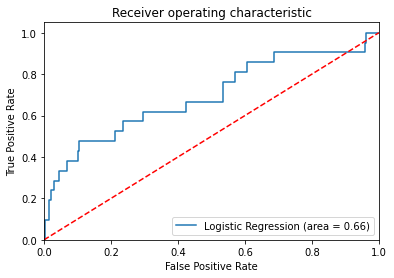

In [ ]:
logistic_regression(X__train__mice__rfe__smote, X__test__mice__rfe , target_var = 'STATUS')

###MICE RFE ROSE LOGREG

Accuracy of logistic regression classifier on test set: 0.77
              precision    recall  f1-score   support

          -1       0.96      0.79      0.87       293
           1       0.15      0.52      0.24        21

    accuracy                           0.77       314
   macro avg       0.56      0.66      0.55       314
weighted avg       0.90      0.77      0.83       314

Average Accuracy: 0.7738853503184714


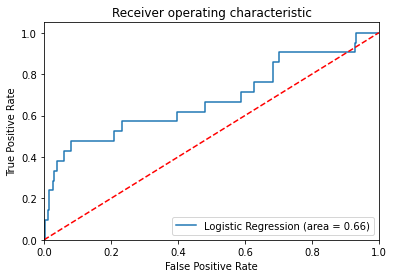

In [ ]:
logistic_regression(X__train__mice__rfe__rose, X__test__mice__rfe , target_var = 'STATUS')